In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score, log_loss


train_df = pd.read_parquet('./data/train_optimized.parquet')
test_df = pd.read_parquet('./data/test_optimized.parquet')

train_df["seq_len"] = train_df["seq"].str.count(",") + 1
train_df["seq_first"] = train_df["seq"].str.split(",", n=1, expand=True)[0].astype("int32")
train_df["seq_last"] = train_df["seq"].str.rsplit(",", n=1).str[-1].astype("int32")

test_df["seq_len"] = test_df["seq"].str.count(",") + 1
test_df["seq_first"] = test_df["seq"].str.split(",", n=1, expand=True)[0].astype("int32")
test_df["seq_last"] = test_df["seq"].str.rsplit(",", n=1).str[-1].astype("int32")

# --- 2. 피처 및 타겟 정의 ---
TARGET = 'clicked'
# ID, seq, 타겟을 제외한 모든 컬럼을 피처로 사용
features = [col for col in train_df.columns if col not in ['ID', 'seq', TARGET]]
categorical_features = [
    'gender', 'age_group', 'inventory_id', 'day_of_week', 'hour', 'seq_len', 'seq_first', 'seq_last'
]
# LightGBM이 카테고리 피처를 인식하도록 타입 변경
for col in categorical_features:
    if col in train_df.columns:
        train_df[col] = train_df[col].astype('category')
        test_df[col] = test_df[col].astype('category')

X_train = train_df[features]
y_train = train_df[TARGET]

# --- 3. 대회 커스텀 평가지표 구현 ---
def weighted_log_loss(y_true, y_pred):
    # 클래스 가중치를 50:50으로 맞춤
    pos_weight = 0.5 / np.mean(y_true)
    neg_weight = 0.5 / (1 - np.mean(y_true))
    loss = - (pos_weight * y_true * np.log(y_pred + 1e-15) + neg_weight * (1 - y_true) * np.log(1 - y_pred + 1e-15))
    return np.mean(loss)

def toss_metric(y_true, y_pred):
    ap = average_precision_score(y_true, y_pred)
    wll = weighted_log_loss(y_true, y_pred)
    score = 0.5 * ap + 0.5 * (1 / (1 + wll))
    return score

# LightGBM용 커스텀 eval 함수
def lgbm_toss_metric(y_true, y_pred):
    """is_higher_better=True 이므로 score를 그대로 반환"""
    return 'toss_score', toss_metric(y_true, y_pred), True

# --- 4. 모델 학습 및 교차 검증 ---
N_SPLITS = 5
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

oof_preds = np.zeros(len(train_df))
test_preds = np.zeros(len(test_df))
cv_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    print(f"===== Fold {fold+1} =====")
    X_train_fold, y_train_fold = X_train.iloc[train_idx], y_train.iloc[train_idx]
    X_val_fold, y_val_fold = X_train.iloc[val_idx], y_train.iloc[val_idx]
    
    # 클래스 불균형 해소를 위한 scale_pos_weight 계산
    scale_pos_weight = np.sum(y_train_fold == 0) / np.sum(y_train_fold == 1)

    lgbm = lgb.LGBMClassifier(
        objective='binary',
        metric='none', # 커스텀 평가지표 사용
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        n_estimators=1000, # 조기 종료를 사용하므로 넉넉하게 설정
        learning_rate=0.05,
        num_leaves=31,
        # 속도 향상을 위한 파라미터
        n_jobs=-1,
    )
    
    lgbm.fit(X_train_fold, y_train_fold,
             eval_set=[(X_val_fold, y_val_fold)],
             eval_metric=lgbm_toss_metric,
             callbacks=[lgb.early_stopping(100, verbose=True)])
    
    val_preds = lgbm.predict_proba(X_val_fold)[:, 1]
    oof_preds[val_idx] = val_preds
    
    fold_score = toss_metric(y_val_fold, val_preds)
    cv_scores.append(fold_score)
    print(f"Fold {fold+1} Score: {fold_score}")

    test_preds += lgbm.predict_proba(test_df[features])[:, 1] / N_SPLITS

print(f"\nAverage CV Score: {np.mean(cv_scores):.5f} (+/- {np.std(cv_scores):.5f})")

# --- 5. 제출 파일 생성 ---
submission = pd.read_csv('./data/sample_submission.csv')
submission['clicked'] = test_preds

from datetime import datetime
now = datetime.now().strftime('%Y%m%d_%H%M%S')
submission.to_csv(f'./submissions/submission_{now}.csv', index=False)
print("Submission file created.")

pd.DataFrame({
    "y_train": y_train,
    "oof_preds": oof_preds
}).to_csv(f"./oof_preds/oof_preds_{now}.csv", index=False)
print(f"oof_preds_*.csv created.")

===== Fold 1 =====
[LightGBM] [Warning] seed is set=42, random_state=42 will be ignored. Current value: seed=42
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] seed is set=42, random_state=42 will be ignored. Current value: seed=42
[LightGBM] [Info] Number of positive: 163343, number of negative: 8400000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.195016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19692
[LightGBM] [Info] Number of data points in the train set: 8563343, number of used features: 120
[LightGBM] [Warning] seed is set=42, random_state=42 will be ignored. Current value: seed=42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019075 -> initscore=-3.940135
[LightGBM] [Info] Start 

FileNotFoundError: [Errno 2] No such file or directory: './data/submission.csv'

In [5]:
p = np.array([1.00, 0.50, 0.67, 0.50, 0.40])
r = np.array([0.50, 0.50, 1.0, 1.0, 1.0])

def ap(p, r):
    ap = 0
    for i in range(len(p)):
        if i == 0:
            ap += p[i] * r[i]
        else:
            ap += p[i] * (r[i] - r[i-1])
    return ap

ap(p, r)



np.float64(0.835)

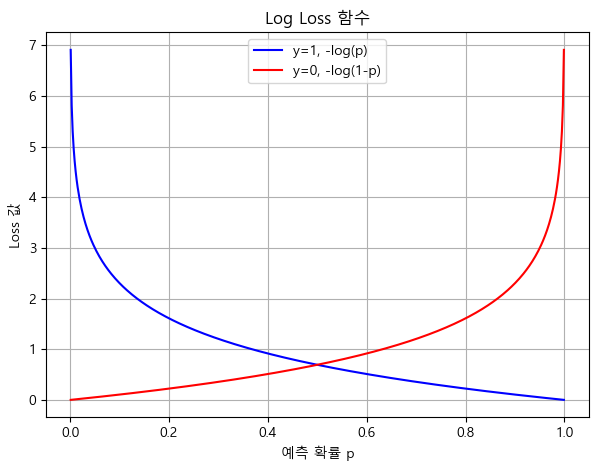

In [8]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rc('font', family='Malgun Gothic')  # 윈도우의 경우 'Malgun Gothic' 사용
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지


# 확률 범위 (0~1)
p = np.linspace(0.001, 0.999, 500)

# log loss for y=1 and y=0
loss_y1 = -np.log(p)
loss_y0 = -np.log(1 - p)

plt.figure(figsize=(7,5))
plt.plot(p, loss_y1, label="y=1, -log(p)", color="blue")
plt.plot(p, loss_y0, label="y=0, -log(1-p)", color="red")
plt.title("Log Loss 함수")
plt.xlabel("예측 확률 p")
plt.ylabel("Loss 값")
plt.legend()
plt.grid(True)
plt.show()
